## EDA part I : Structural metadata and summary statistics

Dataset basic informations :

Structural metadata : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None

Summary statistics : 
       ApplicantIncome  Coappli

<Figure size 1200x800 with 0 Axes>

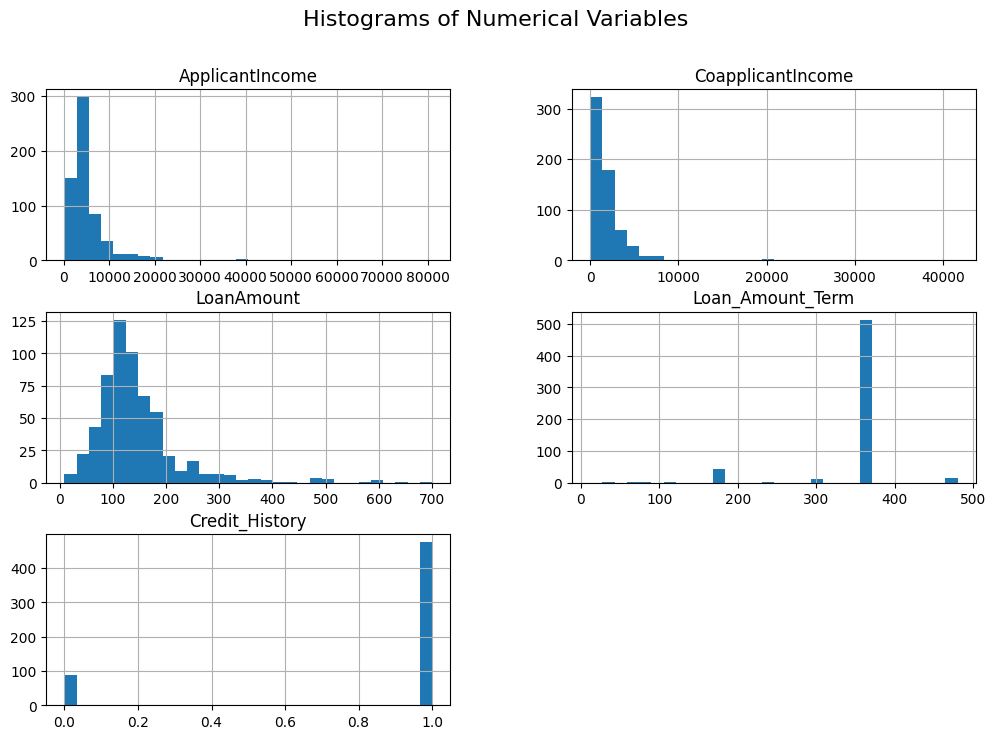


 Skewness of Numerical Features:
CoapplicantIncome    7.491531
ApplicantIncome      6.539513
LoanAmount           2.677552
Credit_History      -1.882361
Loan_Amount_Term    -2.362414
dtype: float64

 Kurtosis of Numerical Features:
{'ApplicantIncome': 60.0390403937373, 'CoapplicantIncome': 84.25637650578992, 'LoanAmount': nan, 'Loan_Amount_Term': nan, 'Credit_History': nan}


In [81]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import kurtosis
import seaborn as sns
import shap



# Load data (adjust path if needed)
df = pd.read_csv("Loan Status Prediction.csv")

# Basic info
print("Dataset basic informations :")


print("\nStructural metadata : ")
print(df.info()) # Number of rows and columns (data points and attributes)

columns_for_summary_stats = ["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term","Credit_History"] # columns we can get the summary stats without cleaning the dataset

print("\nSummary statistics : ")
print(df[columns_for_summary_stats].describe(include="all")) # Summary statistics of the dataset



# Separate numerical and categorical variables
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

print("Numerical Columns:", list(num_cols))
print("Categorical Columns:", list(cat_cols))


# Plotting the histograms of numerical data
plt.figure(figsize=(12, 8))
df[num_cols].hist(bins=30, figsize=(12, 8))
plt.suptitle("Histograms of Numerical Variables", fontsize=16)
plt.show()

# Compute skewness and kurtosis of numerical features
skewness = df[num_cols].skew().sort_values(ascending=False)
print("\n Skewness of Numerical Features:")
print(skewness)
kurtosis_s = {} 
for col in num_cols:
    kurtosis_ = kurtosis(df[col])
    kurtosis_s[col] = float(kurtosis_)
    
print("\n Kurtosis of Numerical Features:")
print(kurtosis_s)

## EDA Part II

Missing values percentage for each variable (%):
                    missing_count  missing_pct
Credit_History                50         8.14
Self_Employed                 32         5.21
LoanAmount                    22         3.58
Dependents                    15         2.44
Loan_Amount_Term              14         2.28
Gender                        13         2.12
Married                        3         0.49
Education                      0         0.00
Loan_ID                        0         0.00
CoapplicantIncome              0         0.00
ApplicantIncome                0         0.00
Property_Area                  0         0.00
Loan_Status                    0         0.00


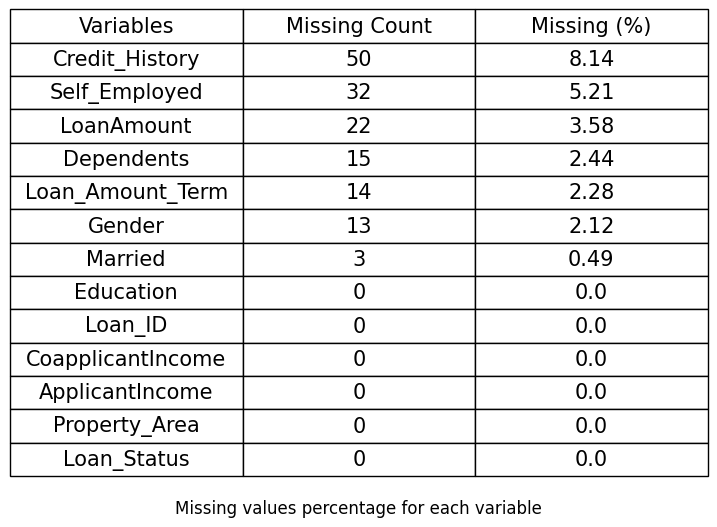


Outlier summary (IQR):
 [{'Variable': 'ApplicantIncome', 'Outliers(number)': 50, 'Outilers(%)': 8.14}, {'Variable': 'CoapplicantIncome', 'Outliers(number)': 18, 'Outilers(%)': 2.93}, {'Variable': 'LoanAmount', 'Outliers(number)': 39, 'Outilers(%)': 6.35}, {'Variable': 'Loan_Amount_Term', 'Outliers(number)': 88, 'Outilers(%)': 14.33}, {'Variable': 'Credit_History', 'Outliers(number)': 89, 'Outilers(%)': 14.5}, {'Variable': 'Dependents', 'Outliers(number)': 0, 'Outilers(%)': 0.0}]


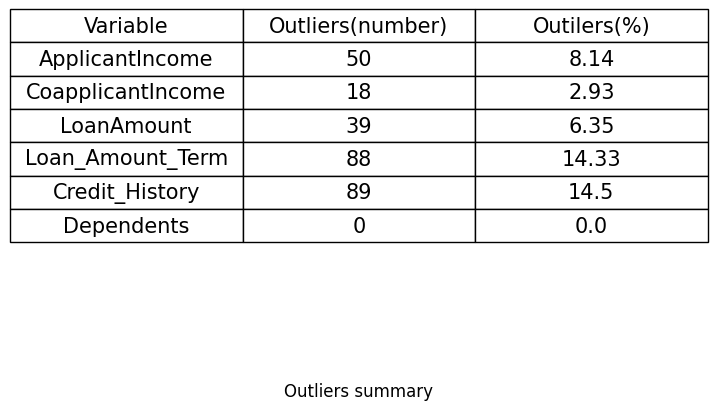

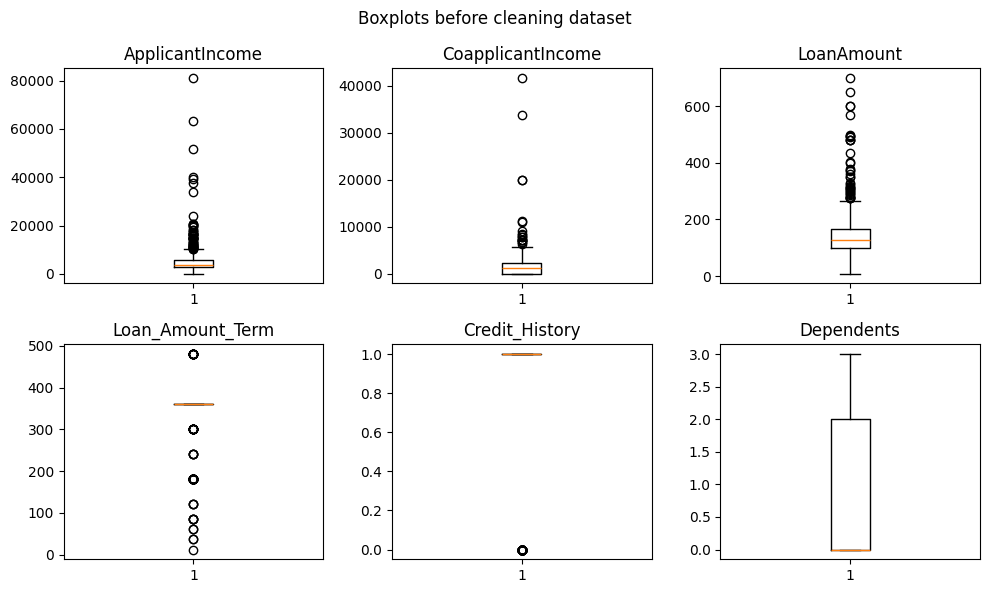

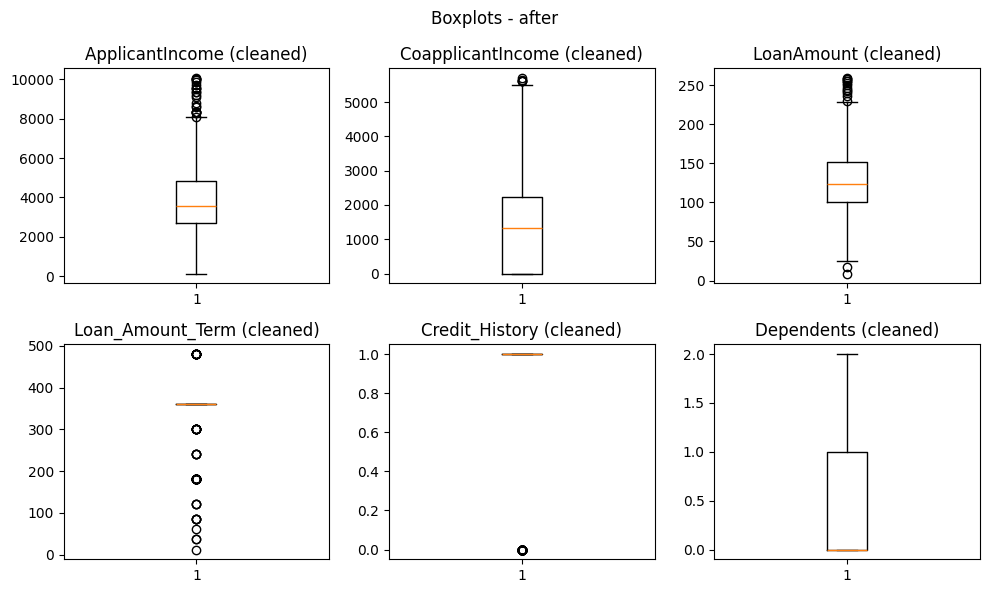

In [82]:


# Convert Dependents {'3+' to 3} and numeric

df['Dependents'] = df['Dependents'].replace('3+', 3)
df['Dependents'] = pd.to_numeric(df['Dependents'], errors='coerce')

# Percentage of missing values in Tables, each variable
missing_vals = (df.isnull().sum().sort_values(ascending=False)).to_frame(name='missing_count')
missing_vals['missing_pct'] = (missing_vals['missing_count'] / len(df) * 100).round(2)
print("Missing values percentage for each variable (%):\n", missing_vals)
# Arrange the missing values data in a datframe
variables = list(missing_vals.index)
rows =  {
    'Variables':[],
    'Missing Count' : [],
    'Missing (%)':[]
    }
for i in range(len(variables)) :
    rows['Variables'].append(variables[i])
    rows['Missing (%)'].append(missing_vals['missing_pct'].iloc[i])
    rows['Missing Count'].append(missing_vals['missing_count'].iloc[i])
    
missing_vals_data = pd.DataFrame(rows)


# function to plot tables
def plot_table(data,title,col_width=1.5,col_height=2):
    table_data = pd.DataFrame(data)

    # Plot table
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.axis('off')  # remove axis

    # Convert DataFrame to matplotlib table
    table = ax.table(
        cellText=table_data.values,       # table values
        colLabels=table_data.columns,     # column headers
        loc='center',
        cellLoc='center'
    )

    # Style
    table.auto_set_font_size(False)
    table.set_fontsize(15)
    table.scale(col_width, col_height)

    plt.title(title,y=-1.3, loc='center', pad=5) 
    plt.show()

#Plot table of missing values summary
plot_table(missing_vals_data,"Missing values percentage for each variable")


# The distributions of numerical data are skewed or non-normal distributions, so we use IQR
# Outliers are data points that fall below (Q_1 - 1.5 * IQR)  or above (Q_3 + 1.5 * IQR).
num_cols = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Credit_History", "Dependents"]
def detect_outliers_iqr(series):
    s = series.dropna() # drop missing values
    q1 = s.quantile(0.25); # Q_1
    q3 = s.quantile(0.75); # Q_3
    iqr = q3 - q1 # IQR
    lower = q1 - 1.5*iqr;  # Q_1 - 1.5 * IQR
    upper = q3 + 1.5*iqr # Q_3 + 1.5 * IQR
    mask = (series < lower) | (series > upper) # range filter  below (Q_1 - 1.5 * IQR)  or above (Q_3 + 1.5 * IQR)
    return mask.fillna(False), lower, upper # return range filtered and bounds

# Outlier summary
outlier_summary_data = []
for c in num_cols: # for each column
    mask, low, up = detect_outliers_iqr(df[c]) # get range filter and bounds to detect outliers
    outlier_summary_data.append(
        {
            'Variable': c,
            'Outliers(number)': int(mask.sum()),
            'Outilers(%)': round(int(mask.sum())/len(df)*100,2)
        }
    )
    
print("\nOutlier summary (IQR):\n", outlier_summary_data)
#plot outliers summary table
plot_table(outlier_summary_data,"Outliers summary")


# Boxplots before handling
plt.figure(figsize=(10,6))
for i,c in enumerate(num_cols):
    plt.subplot(2,3,i+1); 
    plt.boxplot(df[c].dropna()); 
    plt.title(c)
    
plt.suptitle("Boxplots before cleaning dataset")
plt.tight_layout(); 
plt.show()

# Clean dataset : handling missing and outliers
df_clean = df.copy()
# categorical fill mode
cat_cols = ['Gender','Married','Education','Self_Employed','Property_Area']
for c in cat_cols:
    if df_clean[c].isnull().sum()>0: # replace missing values by the mode of the features
        df_clean[c] = df_clean[c].fillna(df_clean[c].mode(dropna=True)[0])
        
# numeric median for missing
for c in num_cols:
    if df_clean[c].isnull().sum()>0: # fill with the median of the features
        df_clean[c] = df_clean[c].fillna(df_clean[c].median())
        
# remove outliers
all_outlier_indices = pd.Index([])
# We don't remove outliers for Loan_Amount_Term and Credit_History because they values are almost constant 
# and removing the few outliers will make us get only constant values for these features
outliers_cols = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Dependents"] 
for c in outliers_cols:
    mask, low, up = detect_outliers_iqr(df_clean[c])
    outlier_idx = df_clean[mask].index
    all_outlier_indices = all_outlier_indices.union(outlier_idx)

# Remove all detected outliers at once
df_clean = df_clean.drop(all_outlier_indices).reset_index(drop=True)
    

# Boxplots after cleaning
plt.figure(figsize=(10,6))
for i,c in enumerate(num_cols):
    plt.subplot(2,3,i+1); 
    plt.boxplot(df_clean[c]); 
    plt.title(c + " (cleaned)")
    
plt.suptitle("Boxplots - after")
plt.tight_layout(); plt.show()


## Feature Engineering

    Loan_ID  Dependents  ApplicantIncome  CoapplicantIncome  LoanAmount  \
0  LP001002         0.0             5849                0.0       128.0   
1  LP001003         1.0             4583             1508.0       128.0   
2  LP001005         0.0             3000                0.0        66.0   
3  LP001006         0.0             2583             2358.0       120.0   
4  LP001008         0.0             6000                0.0       141.0   

   Loan_Amount_Term  Credit_History Loan_Status  TotalIncome  \
0             360.0             1.0           Y       5849.0   
1             360.0             1.0           N       6091.0   
2             360.0             1.0           Y       3000.0   
3             360.0             1.0           Y       4941.0   
4             360.0             1.0           Y       6000.0   

   LoanAmountPerIncome  ...  CoapplicantIncome_log  LoanAmount_log  \
0             0.021884  ...               0.000000        4.859812   
1             0.021015  

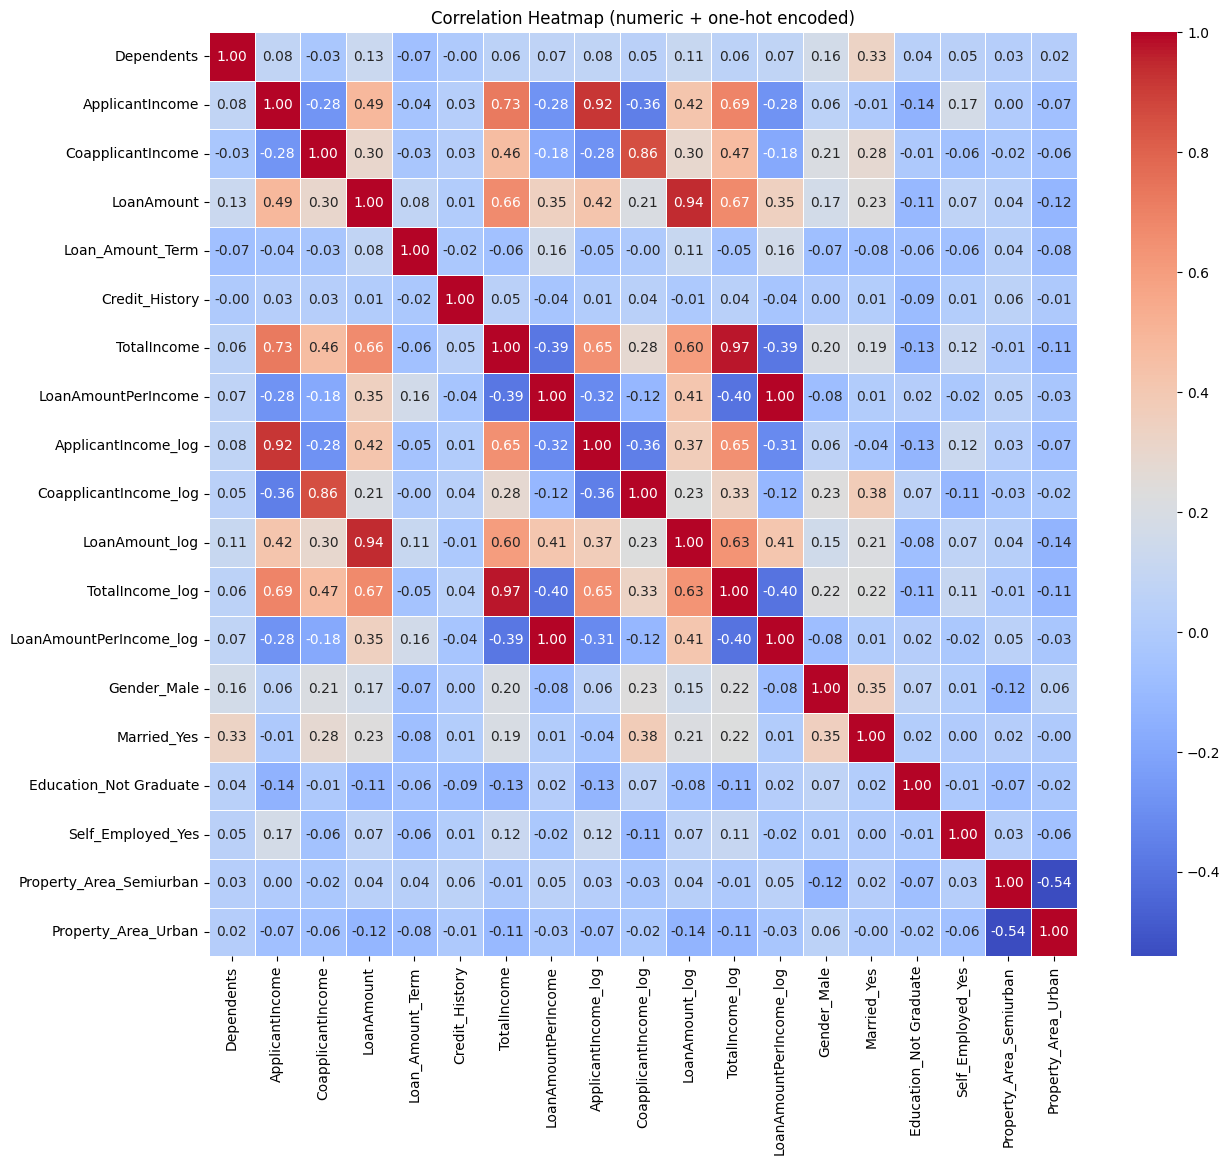


Feature dimension: (495, 19)
Sample feature names: ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'LoanAmountPerIncome', 'ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log', 'TotalIncome_log', 'LoanAmountPerIncome_log', 'Gender_Male', 'Married_Yes', 'Education_Not Graduate', 'Self_Employed_Yes', 'Property_Area_Semiurban', 'Property_Area_Urban']


In [ ]:

# create a new dataframe form the original one
new_df = df_clean.copy()

#Adding new features : total income and loan amount per income
#TotalIncome = ApplicantIncome + CoapplicantIncome
new_df['TotalIncome'] = new_df['ApplicantIncome'] + new_df['CoapplicantIncome']
# LoanAmountPerIncome = LoanAmount / (TotalIncome +tiny to avoid 0 division)
new_df['LoanAmountPerIncome'] = new_df['LoanAmount'] / (new_df['TotalIncome'] + 1e-9)

# using log transforms to normalize the distributions
for c in ['ApplicantIncome','CoapplicantIncome','LoanAmount','TotalIncome','LoanAmountPerIncome']:
    new_df[c+'_log'] = np.log1p(new_df[c])


# Encode Categorical Variables One-Hot Encode
new_df = pd.get_dummies(new_df, columns=['Gender','Married','Education','Self_Employed','Property_Area'], drop_first=True)

print(new_df.head(5))

corr = new_df.drop(columns=['Loan_ID','Loan_Status']).corr()

plt.figure(figsize=(14,12))
sns.heatmap(corr,
            annot=True,    
            cmap='coolwarm',
            fmt=".2f",       
            linewidths=.5)
plt.title("Correlation Heatmap (numeric + one-hot encoded)")
plt.show()

# Prepare features and target
X = new_df.drop(columns=['Loan_ID','Loan_Status'])
y = (new_df['Loan_Status']=='Y').astype(int)

num_features = [c for c in X.columns if X[c].dtype != 'uint8']  # numerical
cat_features = [c for c in X.columns if X[c].dtype == 'uint8']  # one-hot encoded

scaler = RobustScaler()
X_scaled_num = scaler.fit_transform(X[num_features])
X_scaled_num = pd.DataFrame(X_scaled_num, columns=num_features, index=X.index)

# final dataset for modeling
X_final = pd.concat([X_scaled_num, X[cat_features]], axis=1)
print("\nFeature dimension:", X_final.shape)


## Training and Performance Evaluation

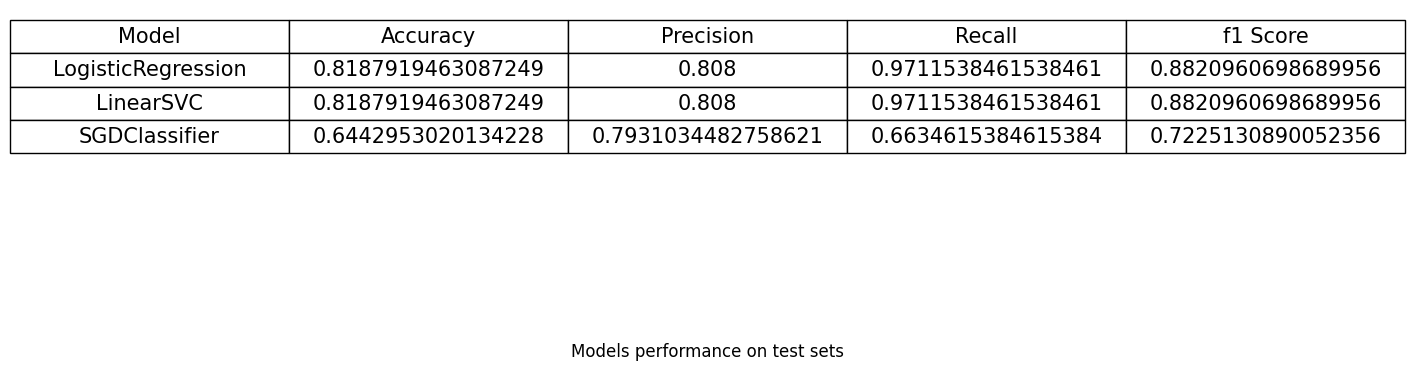

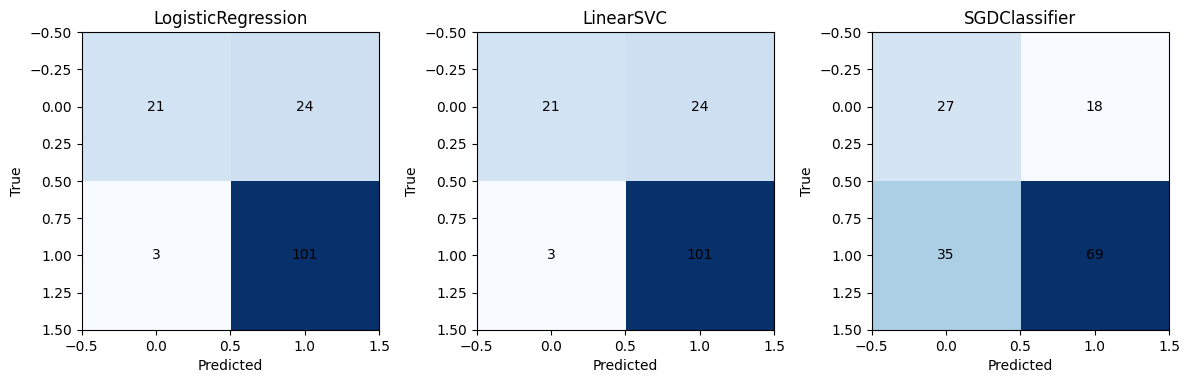

In [84]:

# Split the cleaned dataset into train and test sets(70%,30%)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42, stratify=y)

# Training the 3 linear models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, solver='liblinear'), # Logistic Regression
    'LinearSVC': LinearSVC(max_iter=5000, dual=False), # Linear SVC (support Vector Machine)
    'SGDClassifier': SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=0) #  stochastic gradient descent
}

# Evaluating performance 
results = []
models_y_pred = [] #to plot confusion matrices after
trained_model = {} #save trained models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision' : precision_score(y_test, y_pred, zero_division=0),
        'Recall' : recall_score(y_test, y_pred, zero_division=0),
        'f1 Score': f1_score(y_test, y_pred, zero_division=0)
    })
    
    models_y_pred.append({
        'name': name,
        'y_pred': y_pred
    })
    
    trained_model[name] = model #save trained models
    
    

#plot table of performance metrics
plot_table(results,"Models performance on test sets",3)

# plot confusion matrices
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
i = 0
for data in models_y_pred:
    cm = confusion_matrix(y_test, data['y_pred'])
    plt.subplot(1,3,i+1)
    plt.imshow(cm, cmap='Blues', interpolation='nearest')
    plt.title(data['name'])
    plt.xlabel('Predicted'); plt.ylabel('True')
    
    for r in range(cm.shape[0]):
        for c in range(cm.shape[1]):
            plt.text(c, r, cm[r,c], ha='center', va='center', color='black')
    
    i+=1
    
plt.tight_layout(); 
plt.show()


## Feature contributions to the best model using SHAP

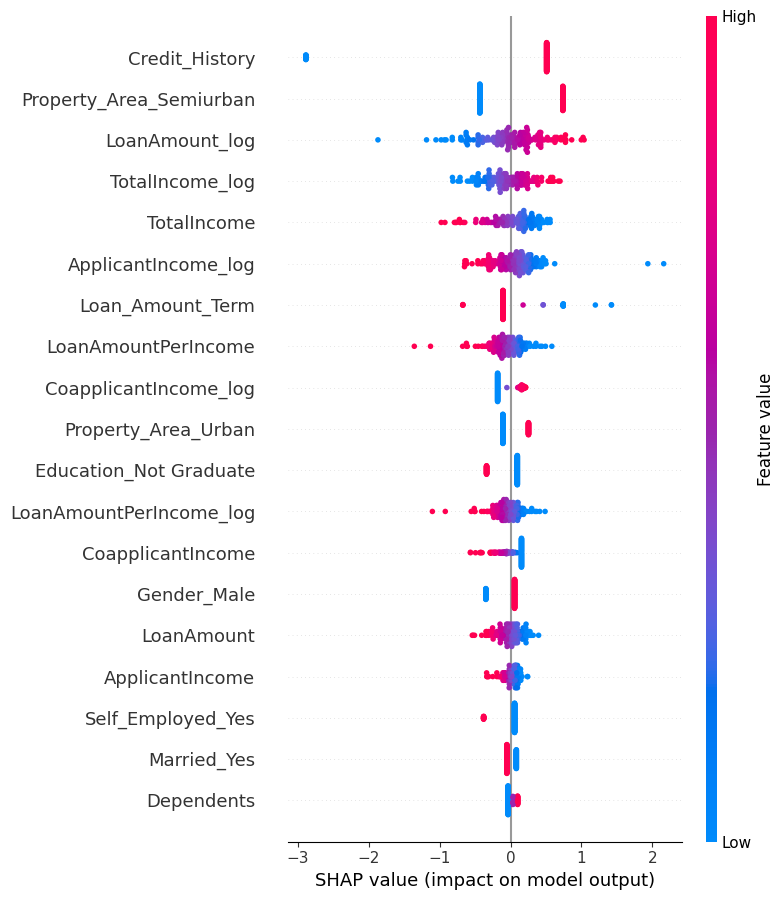

In [85]:

best_model = trained_model['LogisticRegression']


# Create SHAP explainer
explainer = shap.LinearExplainer(best_model, X_train, feature_names=feature_names)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

#Global explanation (summary plot)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)
